# Aprendizaje no supervisado

### Lectura de los datos

In [1]:
#Importaciones
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from numpy import ones, vstack
from numpy.linalg import lstsq

In [2]:
#Lectura de datos
datosGeneracion = pd.read_excel("../Datasets/Información Planta Solar Estacionaria.xlsx")

### Preprocesamiento de los datos

In [3]:
#Variables independientes filtradas
x = datosGeneracion[['Temperatura_diff', 'ProbabilidadLluvia_diff', 'DireccionViento_diff',
                     'IndiceUV_diff', 'CodCondCielo', 'CodDirViento', 'VelocidadRafaga_diff', 'DPT_diff']]

In [11]:
#Escalamiento de las variables independientes e imprimimos la tabla en latex
scaler = MinMaxScaler()
scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(scaled, columns = x.columns)
print(x_scaled.iloc[0:4, :].to_latex(index = False))

\begin{tabular}{rrrrrrrr}
\toprule
Temperatura_diff & ProbabilidadLluvia_diff & DireccionViento_diff & IndiceUV_diff & CodCondCielo & CodDirViento & VelocidadRafaga_diff & DPT_diff \\
\midrule
0.447368 & 0.527950 & 0.494949 & 0.444444 & 0.750000 & 0.375000 & 0.494208 & 0.507246 \\
0.473684 & 0.552795 & 0.494949 & 0.444444 & 0.750000 & 0.375000 & 0.494208 & 0.507246 \\
0.473684 & 0.534161 & 0.494949 & 0.444444 & 0.250000 & 0.375000 & 0.494208 & 0.507246 \\
0.447368 & 0.503106 & 0.494949 & 0.444444 & 0.250000 & 0.375000 & 0.494208 & 0.492754 \\
\bottomrule
\end{tabular}



### K-Means con elección de cluster óptimo mediante Elbow Method

In [13]:
#Ciclo para calcular las inercias para cada cluster disponible
inercias = []
for k in range(2, 10):
  kmeans = KMeans(n_clusters = k).fit(x_scaled.values)
  inercias.append(kmeans.inertia_)

In [16]:
#Se ponen en un dataframe
df_inertias = pd.DataFrame({'n_clusters': range(2, 10), 'inertia': inercias})
print(df_inertias.to_latex(index = False))

\begin{tabular}{rr}
\toprule
n_clusters & inertia \\
\midrule
2 & 1599.126291 \\
3 & 1178.265700 \\
4 & 966.261048 \\
5 & 860.249912 \\
6 & 817.326355 \\
7 & 762.381069 \\
8 & 719.458877 \\
9 & 690.290272 \\
\bottomrule
\end{tabular}



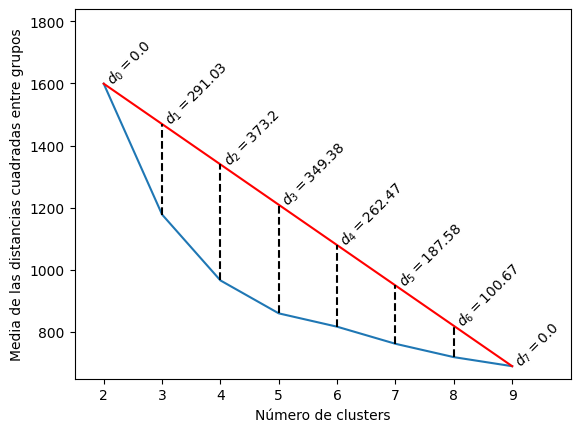

In [17]:
#Gráfica de los puntos de inercia para la elección del más óptimo
points = [(df_inertias.iloc[0, :].n_clusters, df_inertias.iloc[0, :].inertia),
          (df_inertias.iloc[-1, :].n_clusters, df_inertias.iloc[-1, :].inertia)
]
x_coords, y_coords = zip(*points)
A = vstack([x_coords, ones(len(x_coords))]).T
m, b = lstsq(A, y_coords, rcond = None)[0]
plt.figure()
plt.plot(df_inertias.n_clusters, df_inertias.inertia)
plt.plot(df_inertias.iloc[[0, -1], :].n_clusters, df_inertias.iloc[[0, -1], :].inertia, c = 'r')
for i, r in df_inertias.iterrows():
  d = '$d_{' + str(i) + '}' + f' = {abs(round(r.inertia - (m * r.n_clusters + b), 2)):,}$'
  plt.annotate(d, xytext = (r.n_clusters, m * r.n_clusters + b), xy = (r.n_clusters, m * r.n_clusters + b), rotation = 45)
  plt.plot([r.n_clusters, r.n_clusters], [r.inertia, m * r.n_clusters + b], '--k')
plt.xlabel('Número de clusters')
plt.ylabel('Media de las distancias cuadradas entre grupos')
plt.xlim((1.5, 10))
plt.ylim((650, 1.15 * df_inertias.inertia.max()))
plt.xticks(range(2, 10))
plt.show()

### DBSCAN con elección de $\epsilon$ óptimo mediante Nearest Neighbors

In [18]:
#Calculamos con el modelo de Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(x_scaled)
distancias, indices = nbrs.kneighbors(x_scaled)

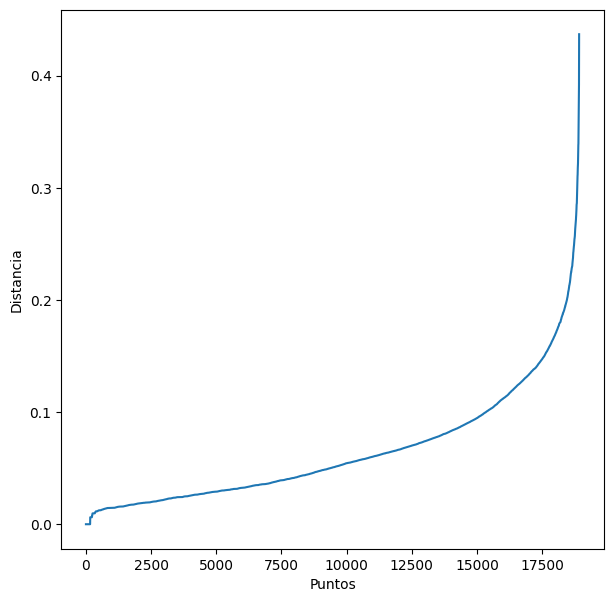

In [19]:
#Calculamos las distancias y graficamos
distancias = np.sort(distancias, axis = 0) #Ordena las distancias
distancias = distancias[:,9] #me quedo con la última columna, la que tiene la mayor distancia

fig = plt.figure(figsize = (7, 7))
plt.plot(distancias)
plt.xlabel("Puntos")
plt.ylabel("Distancia")
plt.show()

### Resultados y métricas de evaluación

In [20]:
#KMeans con 4 clusters
kmeans = KMeans(n_clusters = 4, n_init = 'auto').fit(x_scaled)
datosGeneracion["kmeans"] = kmeans.labels_

In [23]:
#Imprimimos agrupamiento de acuerdo al KMeans
print(datosGeneracion.groupby(["kmeans"])["kmeans"].count().to_latex())

\begin{tabular}{lr}
\toprule
 & kmeans \\
kmeans &  \\
\midrule
0 & 6868 \\
1 & 5474 \\
2 & 3310 \\
3 & 3270 \\
\bottomrule
\end{tabular}



In [24]:
#Métricas de silueta y DB
kmeans_s = silhouette_score(x_scaled, kmeans.labels_)
kmeans_db = davies_bouldin_score(x_scaled, kmeans.labels_)
print(kmeans_s, kmeans_db)

0.3915912465905186 1.039691126091597


In [25]:
#DBSCAN con épsilon de 0.21
dbscan = DBSCAN(eps = 0.21, min_samples = 10).fit(x_scaled)
datosGeneracion["dbscan"] = dbscan.labels_

In [26]:
#Imprimimos agrupamiento de acuerdo al DBSCAN
print(datosGeneracion.groupby(["dbscan"])["dbscan"].count().to_latex())

\begin{tabular}{lr}
\toprule
 & dbscan \\
dbscan &  \\
\midrule
-1 & 124 \\
0 & 2259 \\
1 & 993 \\
2 & 959 \\
3 & 9664 \\
4 & 4923 \\
\bottomrule
\end{tabular}



In [28]:
dbscan_s = silhouette_score(x_scaled, dbscan.labels_)
dbscan_db = davies_bouldin_score(x_scaled, dbscan.labels_)
print(dbscan_s, dbscan_db)

0.23160206008016362 4.75283420421491
